<img src="https://uploads-ssl.webflow.com/5eae007d92687089219c5dec/5eb47da29ced78042e9768ce_long_logo.png" align="right" border="0" width="35%" >

# Montecarlo Simulation of SP500, Apple & Microsoft

**Optimal portfolio Mean-Variance Markowitz Approach**

Import the required packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from yahoofinancials import YahooFinancials
import scipy.optimize as sco

Download the stock prices

In [2]:
# Select Tickers and stock history dates
ticker = 'AAPL'
ticker2 = 'MSFT'
ticker3 = 'SPY'
ticker4 = 'AMZN'
freq = 'daily'
start_date = '2019-01-01'
end_date = '2020-05-01'


# Function to clean data extracts
def clean_stock_data(stock_data_list):
    new_list = []
    for rec in stock_data_list:
        if 'type' not in rec.keys():
            new_list.append(rec)
    return new_list

# Construct yahoo financials objects for data extraction
aapl_financials = YahooFinancials(ticker)
mfst_financials = YahooFinancials(ticker2)
spy_financials = YahooFinancials(ticker3)
amzn_financials = YahooFinancials(ticker4)



# Clean returned stock history data and remove dividend events from price history

daily_aapl_data = clean_stock_data(aapl_financials
                                     .get_historical_price_data(start_date, end_date, freq)[ticker]['prices'])
daily_msft_data = clean_stock_data(mfst_financials
                                     .get_historical_price_data(start_date, end_date, freq)[ticker2]['prices'])
daily_spy_data = clean_stock_data(spy_financials
                                     .get_historical_price_data(start_date, end_date, freq)[ticker3]['prices'])
daily_amzn_data = clean_stock_data(amzn_financials
                                     .get_historical_price_data(start_date, end_date, freq)[ticker4]['prices'])


# Function to construct data frame based on a stock and it's market index
def build_data_frame(data_list1, data_list2, data_list3, data_list4):
    data_dict = {}
    i = 0
    for list_item in data_list2:
        if 'type' not in list_item.keys():
            data_dict.update({list_item['formatted_date']: {'SPY': data_list3[i]['close'], 
                                                            'AAPL': data_list1[i]['close'],
                                                            'MSFT': data_list2[i]['close'],
                                                            'AMZN': data_list4[i]['close']
                                                            }})
            i += 1
    tseries = pd.to_datetime(list(data_dict.keys()))
    df = pd.DataFrame(data=list(data_dict.values()), index=tseries,
                      columns=['AAPL', 'MSFT', 'SPY', 'AMZN']).sort_index()
    return df

rawdata = build_data_frame(daily_aapl_data, daily_msft_data, daily_spy_data, daily_amzn_data)

## Code from:
## https://stackoverflow.com/questions/49705047/downloading-mutliple-stocks-at-once-from-yahoo-finance-python

Calculate Returns

In [3]:
returns = np.log(rawdata/rawdata.shift(1))
returns.columns = ['AAPL','MSFT','SPY','AMZN']
returns = returns[1:]

returns.head()

,AAPL,MSFT,SPY,AMZN
2019-01-03,-0.104924,-0.037482,-0.024152,-0.025566
2019-01-04,0.041803,0.045460,0.032947,0.048851
2019-01-07,-0.002228,0.001275,0.007854,0.033776
2019-01-08,0.018884,0.007225,0.009351,0.016476
2019-01-09,0.016839,0.014198,0.004663,0.001713


### Histogram of Returns & Correlations

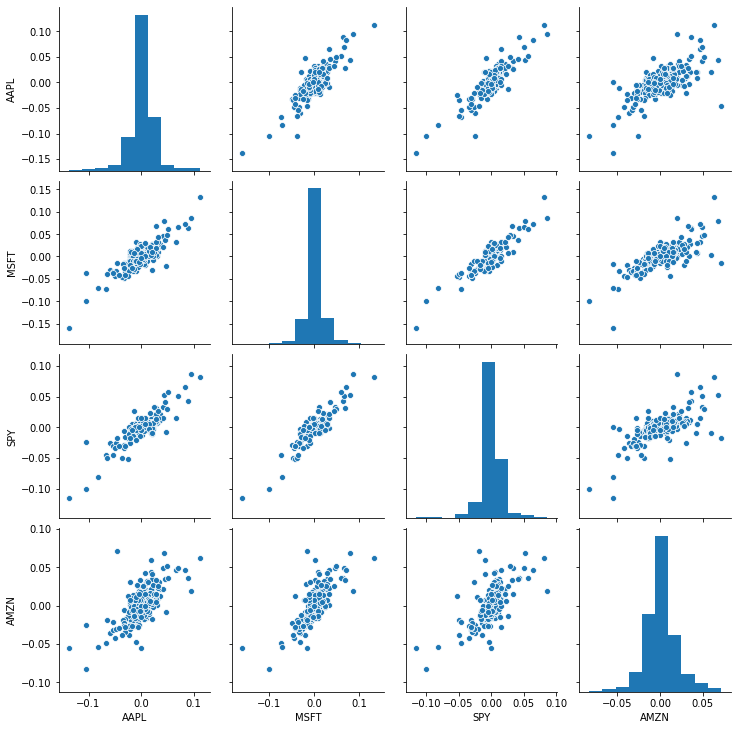

In [4]:
sns.pairplot(data=returns)
plt.show()

### Monte Carlo Simulation of 5,000 portfolios

In [5]:

np.random.seed(21)
num_ports = 5000
all_weights = np.zeros((num_ports, len(returns.columns)))
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)
risk_free = 0.02

for x in range(num_ports):
    # Weights
    weights = np.array(np.random.random(4))
    weights = weights/np.sum(weights)
    
    # Save weights
    all_weights[x,:] = weights
    
    # Expected return
    ret_arr[x] = np.sum( (returns.mean() * weights * 252))
    
    # Expected volatility
    vol_arr[x] = np.sqrt(np.dot(weights.T, np.dot(returns.cov()*252, weights)))
    
    # Sharpe Ratio
    sharpe_arr[x] = ( ret_arr[x]- risk_free) /vol_arr[x]

### Printing Results

In [6]:
print("Max Sharpe Ratio using MC Simulation: {}".format(sharpe_arr.max()))
#print("Its location: {}".format(sharpe_arr.argmax()))

w = [round(i*100,2)for i in all_weights[sharpe_arr.argmax(),:]]
w = pd.DataFrame(w, columns = ['Weight (%)'], index = returns.columns)

print("\n")
print(w)
print("\n")


max_sr_ret = ret_arr[sharpe_arr.argmax()]
max_sr_vol = vol_arr[sharpe_arr.argmax()]

Max Sharpe Ratio using MC Simulation: 1.2582226557258906


      Weight (%)
AAPL       37.15
MSFT       12.13
SPY         0.14
AMZN       50.57




### Scatter Plot with Portfolio Returns

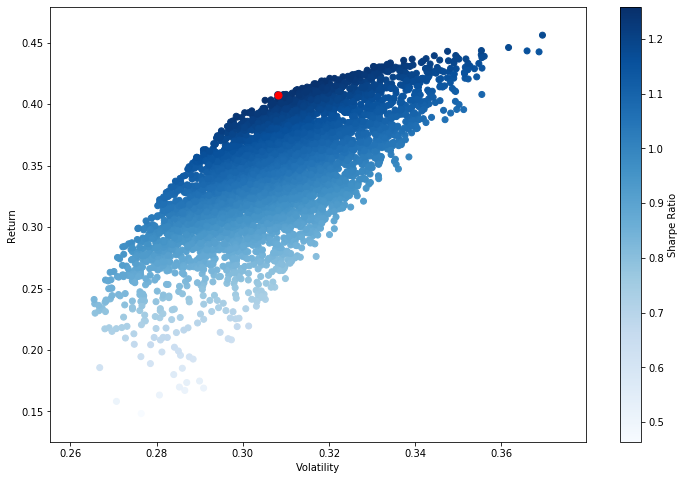

In [7]:
plt.figure(figsize=(12,8))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='Blues')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.scatter(max_sr_vol, max_sr_ret,c='red', s=50) # red dot
plt.show()

### Optimizer to find best Sharpe Ratio Portfolio

In [8]:
def get_ret_vol_sr(weights):
    weights = np.array(weights)
    ret = np.sum(returns.mean() * weights) * 252
    vol = np.sqrt(np.dot(weights.T, np.dot(returns.cov()*252, weights)))
    sr = ret/vol
    return np.array([ret, vol, sr])

def neg_sharpe(weights):
# the number 2 is the sharpe ratio index from the get_ret_vol_sr
    return get_ret_vol_sr(weights)[2] * -1

def check_sum(weights):
    #return 0 if sum of the weights is 1
    return np.sum(weights)-1

# Set constrains and initial guess
cons = ({'type':'eq', 'fun':check_sum})
bounds = ((0,1),(0,1),(0,1),(0,1))
init_guess = [0.25,0.25,0.25,0.25]

opt_results = sco.minimize(neg_sharpe, init_guess, method = 'SLSQP', bounds = bounds, constraints=cons)
print(opt_results)
print("\n")
print("Return, Volatility, Sharpe")
get_ret_vol_sr(opt_results.x)

     fun: -1.3241376828232725
     jac: array([-6.47008419e-05,  3.60161066e-05,  6.75130367e-01,  3.98755074e-05])
 message: 'Optimization terminated successfully.'
    nfev: 36
     nit: 6
    njev: 6
  status: 0
 success: True
       x: array([0.3765373 , 0.12592434, 0.        , 0.49753836])


Return, Volatility, Sharpe


array([0.40890377, 0.30880759, 1.32413768])

### Creating Efficient Frontier

In [9]:
frontier_y = np.linspace(0.26,0.44,200)

def minimize_volatility(weights):
    return get_ret_vol_sr(weights)[1]

frontier_x = []

for possible_return in frontier_y:
    cons = ({'type':'eq', 'fun':check_sum},
            {'type':'eq', 'fun': lambda w: get_ret_vol_sr(w)[0] - possible_return})
    
    result = sco.minimize(minimize_volatility,init_guess,method='SLSQP', bounds=bounds, constraints=cons)
    frontier_x.append(result['fun'])

### Graph Frontier

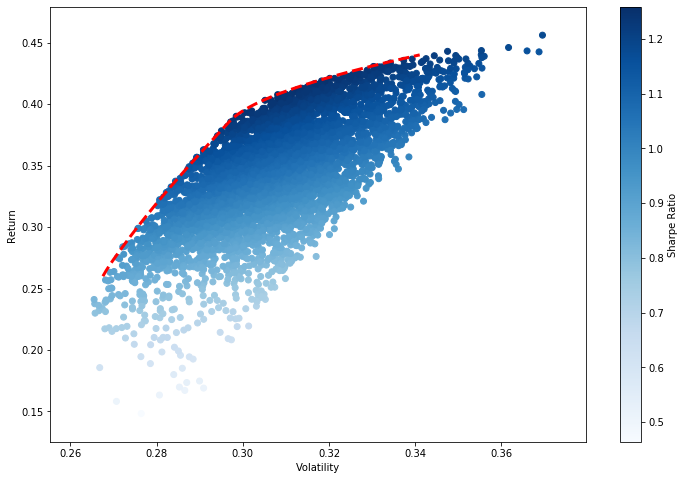

In [10]:
plt.figure(figsize=(12,8))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='Blues')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.plot(frontier_x,frontier_y, 'r--', linewidth=3)
plt.savefig('cover.png')
plt.show()


<img src="https://uploads-ssl.webflow.com/5eae007d92687089219c5dec/5eb47da29ced78042e9768ce_long_logo.png" align="right" border="0" width="35%" > <br>